# Thema 3 werkcollege 1: Word Embeddings
In dit werkcollege gaan we aan de slag met Word embeddings. Op de elo vind je een bestand `gamereviews.xlsx`met daarin 100.000 videogames reviews van Amazon (Orginenele bestand http://jmcauley.ucsd.edu/data/amazon/index_2014.html). Voor iedere revuew is het `sentiment` (1 positief; 0 negatief) bepaald op het aantal gegeven sterren (1-2 negatief; 4-5 positief) Verder bevat het bestand een kolom `reviewText` met daarin de daadwerkelijke review. We gaan proberen om op basis de text proberen te voorspellen of een review positief of negatief is. 
- lees het bestand in
- maak een variabele `text`aan met daarin de reviews als string
- maak een variabele `sentiment` aan met daarin een 1 als er 4 of 5 sterren gegeven zijn en een 0 als er 1 of 2 sterren gegeven zijn. Geef deze als tyoe int 

In [2]:
# conda install openpyxl
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt

In [3]:
# lees het bestand gamereviews in in een pandas dataframe

gamereviews = pd.read_excel("Data/gamereviews.xlsx",converters={'reviewText':str},dtype={'reviewText':str})
gamereviews.info()
gamereviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100000 non-null  int64 
 1   sentiment   100000 non-null  int64 
 2   reviewText  99980 non-null   object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


/var/folders/g_/05t9yvy52y731p3lghybrmbr0000gn/T/ipykernel_25725/1249887774.py:3: ParserWarning: Both a converter and dtype were specified for column reviewText - only the converter will be used.
  gamereviews = pd.read_excel("Data/gamereviews.xlsx",converters={'reviewText':str},dtype={'reviewText':str})


,Unnamed: 0,sentiment,reviewText
0,0,0,"If you're looking for immersive gameplay, good..."
1,1,0,The zippers on this bag are terrible. I ordere...
2,2,1,"If you need a good intro to Wii games, this is..."
3,3,1,This game has brought back so many great memor...
4,4,1,True Crime: Streets of LA was my first experie...


In [4]:
# Split deze in een variabele text en een variabele sentiment met daarin de sentimenten
text = gamereviews['reviewText'].apply(str)
sentiment = gamereviews['sentiment']

In [5]:
print(text.shape)
text[0]

(100000,)


"If you're looking for immersive gameplay, good story and graphics...then don't buy this game.  At first I thought this would be a Max Payne knock-off, which would be fine because that was a great game.  Unfortunately this game can't even be put into the same category.\nFirst off, the graphics are just ok.  There's nothing wrong with them, but I'm playing on an X Box here.  The graphics should be great.  I would even have to say the the graphics on Max Payne for the PS2 are better.  The introduction was interesting and visually very good.  It's too bad that this doesn't carry on into the rest of the game.\nThe storyline is moderately cheesy.  If I'm playing a Mature rated game (which this is) then I'd prefer to have a story made for adults.  Often I would find myself thrown into a situation where I just had to kill everyone in sight.  Once that was done, more bad guys appear and then a few more after that.  All the while I'm not even sure why I'm there in the first place.\nI've seen a 

We hebben nu 100.000 reviews, waarvan er 50.000 positief zijn. We gaan nu de tokenizen zodat ieder woord een eigen integer waarde krijgt. 

In [6]:
#tokenize de tekst ga uit van max 10.000 woorden

WORD_COUNT = 10000

tokenizer = Tokenizer(num_words=WORD_COUNT)
tokenizer.fit_on_texts(text)
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'i': 6,
 'game': 7,
 'is': 8,
 'you': 9,
 'it': 10,
 'this': 11,
 'in': 12,
 'that': 13,
 'for': 14,
 'are': 15,
 'but': 16,
 'with': 17,
 'on': 18,
 'have': 19,
 'as': 20,
 'not': 21,
 'was': 22,
 'be': 23,
 'all': 24,
 'if': 25,
 'your': 26,
 'like': 27,
 'so': 28,
 'one': 29,
 'can': 30,
 'or': 31,
 'games': 32,
 'my': 33,
 'just': 34,
 'they': 35,
 'get': 36,
 'at': 37,
 'there': 38,
 'play': 39,
 'from': 40,
 "it's": 41,
 'out': 42,
 'will': 43,
 'more': 44,
 'up': 45,
 'an': 46,
 'time': 47,
 'has': 48,
 'no': 49,
 'when': 50,
 'very': 51,
 'good': 52,
 'even': 53,
 'some': 54,
 'great': 55,
 'only': 56,
 'about': 57,
 'me': 58,
 'do': 59,
 'really': 60,
 'what': 61,
 "don't": 62,
 'first': 63,
 'fun': 64,
 'which': 65,
 'other': 66,
 'by': 67,
 'much': 68,
 'would': 69,
 'graphics': 70,
 'them': 71,
 '2': 72,
 'also': 73,
 'than': 74,
 'had': 75,
 'because': 76,
 'well': 77,
 'then': 78,
 'new': 79,
 'its': 80,
 'after': 81,
 '

Nu hebben we eerder al gezien dat niet alle reviews even lang zijn. Daarom gaan we deze aanvullen (padding) naar 50 woorden. Lange reviews worden afgekapt. Ivm de performance beperken we ons hier tot de 1e 50 woorden.

In [7]:
#vul de reviews aan tot 50 woorden
WORDS_IN_SEQUENCE = 50
sequences = tokenizer.texts_to_sequences(text)
sequences = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=WORDS_IN_SEQUENCE)
sequences[0]

array([   3,   23,    2,  356,   34,  100,   49,  552,   18,    1, 1264,
         11,    7, 1645,   20,  169,   10,   69,   23,   51,   52,    2,
          6, 1780,   13,   10,   75,    1, 1155,    3,   23,   51,   52,
         41,   92,  122,   13,   28,   99,  154,  104, 4329,    2,  144,
         11,   88,    4, 1005,  122,    7], dtype=int32)

We gaan nu sequentieel model bouwen en fitten. Het model bestaat uit een embedding layer, een flatten layer en sluit af met een Dense layer met 1 neuron. De embedding layer geven we 10.000 woorden als max en 100 dimensies. 

In [8]:
#bouw een model met een embedding layer
DIMS = 100
model = models.Sequential([
    layers.Embedding(input_dim=WORD_COUNT, output_dim=DIMS, input_length=WORDS_IN_SEQUENCE),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
])

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
#compile en fit het model. epochs=10 validation_split=0.2
# output = 1 tensor, dat de `sentiment` moet zijn

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(sequences, sentiment, epochs=10, validation_split=0.2)

# if not histories exists, create one and add the next
if 'histories' not in locals():
    histories = []
histories.append(history)

2024-09-30 15:16:30.931840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-30 15:16:30.931885: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-30 15:16:30.931901: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-30 15:16:30.932237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-30 15:16:30.932266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-09-30 15:16:31.387305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.7984 - loss: 0.1401 - val_accuracy: 0.8736 - val_loss: 0.0920
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.9208 - loss: 0.0617 - val_accuracy: 0.8838 - val_loss: 0.0859
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.9647 - loss: 0.0323 - val_accuracy: 0.8828 - val_loss: 0.0888
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.9816 - loss: 0.0178 - val_accuracy: 0.8798 - val_loss: 0.0930
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.9878 - loss: 0.0118 - val_accuracy: 0.8735 - val_loss: 0.1002
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.9891 - loss: 0.0100 - val_accuracy: 0.8745 - val_loss: 0.1007
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.9909 - loss: 0.0082 - val_accuracy: 0.8694 - val_loss: 0.1061
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.9925 - loss: 0.00

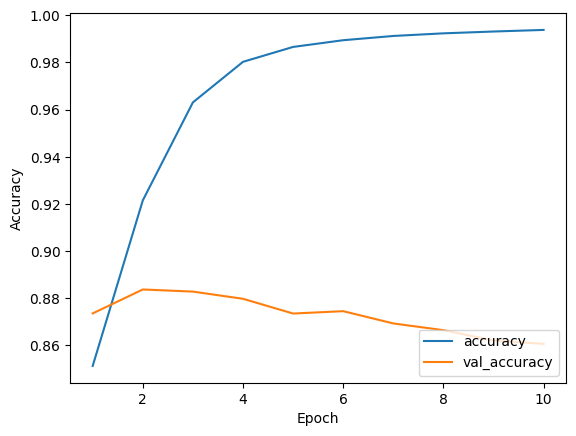

In [10]:
acc=histories[-1].history['accuracy']
val_acc=histories[-1].history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Wat valt hier op? 

We testen ons model ook even met een paar eigenbedachte tweets. Schrijf hiervoor de code

In [11]:
#test een zelfbedachte tweet. Zorg ervoor dat er negative of positive uitkomt
def rateTweet(tweet_text):
    tweet = tokenizer.texts_to_sequences([tweet_text])
    tweet = keras.preprocessing.sequence.pad_sequences(tweet, maxlen=WORDS_IN_SEQUENCE)
    prediction = model.predict(tweet, verbose=0)
    if prediction[0][0] > 0.5:
        print("Positive: " + tweet_text)
    else:
        print("Negative: " + tweet_text)

rateTweet("I love this game, it is the best game ever")
rateTweet("I hate this game, it is the worst game ever")
rateTweet("This game is decent")
rateTweet("This game is kind of decent")
rateTweet("Awesome.")

Positive: I love this game, it is the best game ever
Negative: I hate this game, it is the worst game ever
Negative: This game is decent
Negative: This game is kind of decent
Positive: Awesome.


Vaak heb je onvoldoende data om zelf alles te trainen. Gelukkig is dit voor Engels al veelvuldig gedaan. Een bekend voorbeeld hiervan is GloVe (Global Vectors for words). We beginnen daarom met het downloaden van Glove [https://nlp.stanford.edu/projects/glove/] en download de 2014 English Wikipedia. Dit is een zipfile met daarin 100-dimensionale vectors voor 400.000 engelse woorden.

In [12]:
#download glove. Pas het path aan en run de onderstaande code
import os
import numpy as np
glove_dir = 'Data/glove.6B/'


embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(embeddings_index['the'])  #voorbeeld van een willekeurig woord

Found 400000 word vectors.
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0

Als het goed is zijn er nu 400000 vectors ingelezen. De volgende stap is het omzetten van de variabele embedding_index in een matrix die we aan een embedding layer kunnen voeren. Deze moet de vorm max_features, embedding_dim hebben. In dit geval dus 20.000 woorden en 100 dimensies.  

In [13]:
#Bestudeer, begrijp en run de onderstaande code
embedding_dim = 100

max_features = WORD_COUNT

embedding_matrix = np.zeros((max_features, embedding_dim)) #initialiseren alles op 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:   # als het woord gevonden is
            embedding_matrix[i] = embedding_vector

embedding_matrix[3] #voorbeeldje

array([-1.89700007e-01,  5.00239991e-02,  1.90840006e-01, -4.91839983e-02,
       -8.97369981e-02,  2.10060000e-01, -5.49520016e-01,  9.83769968e-02,
       -2.01350003e-01,  3.42409998e-01, -9.26769972e-02,  1.60999998e-01,
       -1.32679999e-01, -2.81599998e-01,  1.87370002e-01, -4.29589987e-01,
        9.60389972e-01,  1.39719993e-01, -1.07809997e+00,  4.05180007e-01,
        5.05389988e-01, -5.50639987e-01,  4.84400004e-01,  3.80439997e-01,
       -2.90549989e-03, -3.49420011e-01, -9.96960029e-02, -7.83680022e-01,
        1.03629994e+00, -2.31399998e-01, -4.71210003e-01,  5.71259975e-01,
       -2.14540005e-01,  3.59580010e-01, -4.83190000e-01,  1.08749998e+00,
        2.85239995e-01,  1.24470003e-01, -3.92480008e-02, -7.67320022e-02,
       -7.63429999e-01, -3.24090004e-01, -5.74899971e-01, -1.08930004e+00,
       -4.18110013e-01,  4.51200008e-01,  1.21119998e-01, -5.13670027e-01,
       -1.33489996e-01, -1.13779998e+00, -2.87680000e-01,  1.67740002e-01,
        5.58040023e-01,  

Ons model blijft gelijk met eerder. Dus hier hoeven we niks aan te veranderen

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 50, 100)          │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 5000)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │         5,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,015,005 (11.50 MB)

 Trainable params: 1,005,001 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,010,004 (7.67 MB)

We laden onze variabele embedding_matrix in als <u>weight</u> (tip: gebruik set_weights) bij de embedding layer [0].
Aangezien we de bestaande glove matrix willen gebruiken en niet opnieuw gaan trainen zetten we trainable op False

In [15]:
#gebruik de embedding_matrix als weigth bij de embed_layer en set trainable of false

model.layers[0].set_weights([embedding_matrix])

# Waarom: "You called `set_weights(weights)` on layer 'embedding_2' with a weight list of length 10000, but the layer was expecting 1 weights."
# Omdat het

model.layers[0].trainable = False

We compilen en fitten het model opnieuw.

In [16]:
#compile en fit het model

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history2 = model.fit(sequences, sentiment, epochs=10, validation_split=0.2)

# if not histories exists, create one and add the next
if 'histories' not in locals():
    histories = []
histories.append(history)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.5405 - loss: 0.4172 - val_accuracy: 0.6459 - val_loss: 0.3160
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6748 - loss: 0.2881 - val_accuracy: 0.6921 - val_loss: 0.2709
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7233 - loss: 0.2438 - val_accuracy: 0.7123 - val_loss: 0.2539
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7432 - loss: 0.2260 - val_accuracy: 0.7272 - val_loss: 0.2371
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7613 - loss: 0.2091 - val_accuracy: 0.7354 - val_loss: 0.2295
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7724 - loss: 0.1994 - val_accuracy: 0.7398 - val_loss: 0.2282
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7830 - loss: 0.1898 - val_accuracy: 0.7462 - val_loss: 0.2206
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7888 - loss: 0

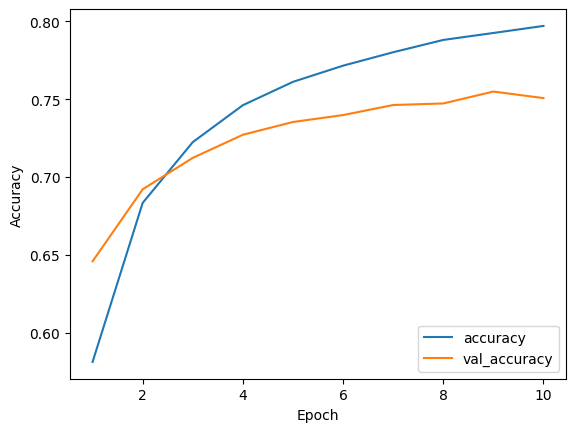

In [19]:
#plot de accuracy en validated accuracy
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Wat valt hier op?

Hieronder volgt nog een leuk stukje visualisatie van wat GloVe precies allemaal doet

We beginnen met een lijstje met redelijk willekeurige woorden die we opzoeken in de GloVe dictionary. Dit geeft ons per word 50 verschilende waarden. Nu is een 50-dimensionale figuur vrij lastig te visualiseren, daarom reduceren we dit door middel van Principal Component Analysis tot 2 (zie https://en.wikipedia.org/wiki/Principal_component_analysis) en plotten we deze.

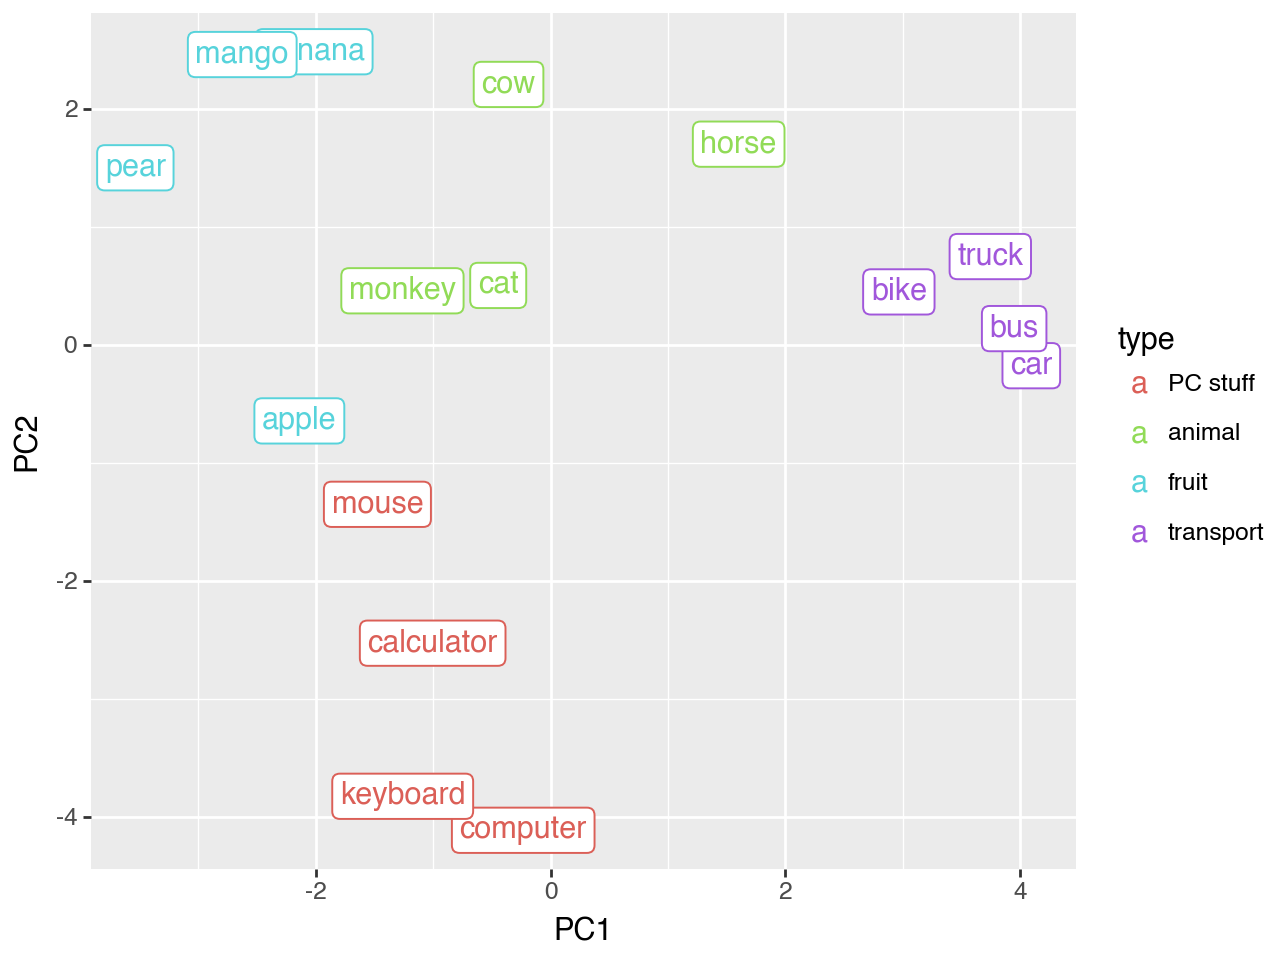

In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from plotnine import *

words = ['horse', 'cow', 'monkey', 'cat', 'apple', 'banana', 'pear', 'mango',
         'car', 'bus', 'truck', 'bike', 'computer', 'calculator', 'keyboard', 'mouse']

plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([embeddings_index[w] for w in words]),
                         columns=['PC1', 'PC2'])

plot_word['word'] = words
plot_word['type'] = list(pd.Series(['animal', 'fruit', 'transport', 'PC stuff']).repeat(4))

gg = (
    ggplot(plot_word, aes(x='PC1', y='PC2')) +
      geom_point(aes(color='type')) +
      geom_label(aes(label='word', color='type'))
)
gg

Wat hier opvalt is dat veel vervante woorden (zoals bijvoorbeeld de voertuigen) allemaal redelijk dicht bij elkaar liggen. Wat ook opvalt is dat 'apple' tussen de fruitsoorten en de computer onderdelen is geplaatst. Hetzelde geldt ook enigszins voor 'mouse'

Nu is zijn niet alleen losse woorden heel interessant, maar ook hoe woorden zich tot elkaar verhouden. Daarom plotten we in dit geval een aantal landen en hoofdsteden. wat hierbij opvalt is dat dat tussen liggende vector (verplaatsing op de x en de y-as) bij veel landen min of meer gelijk is.

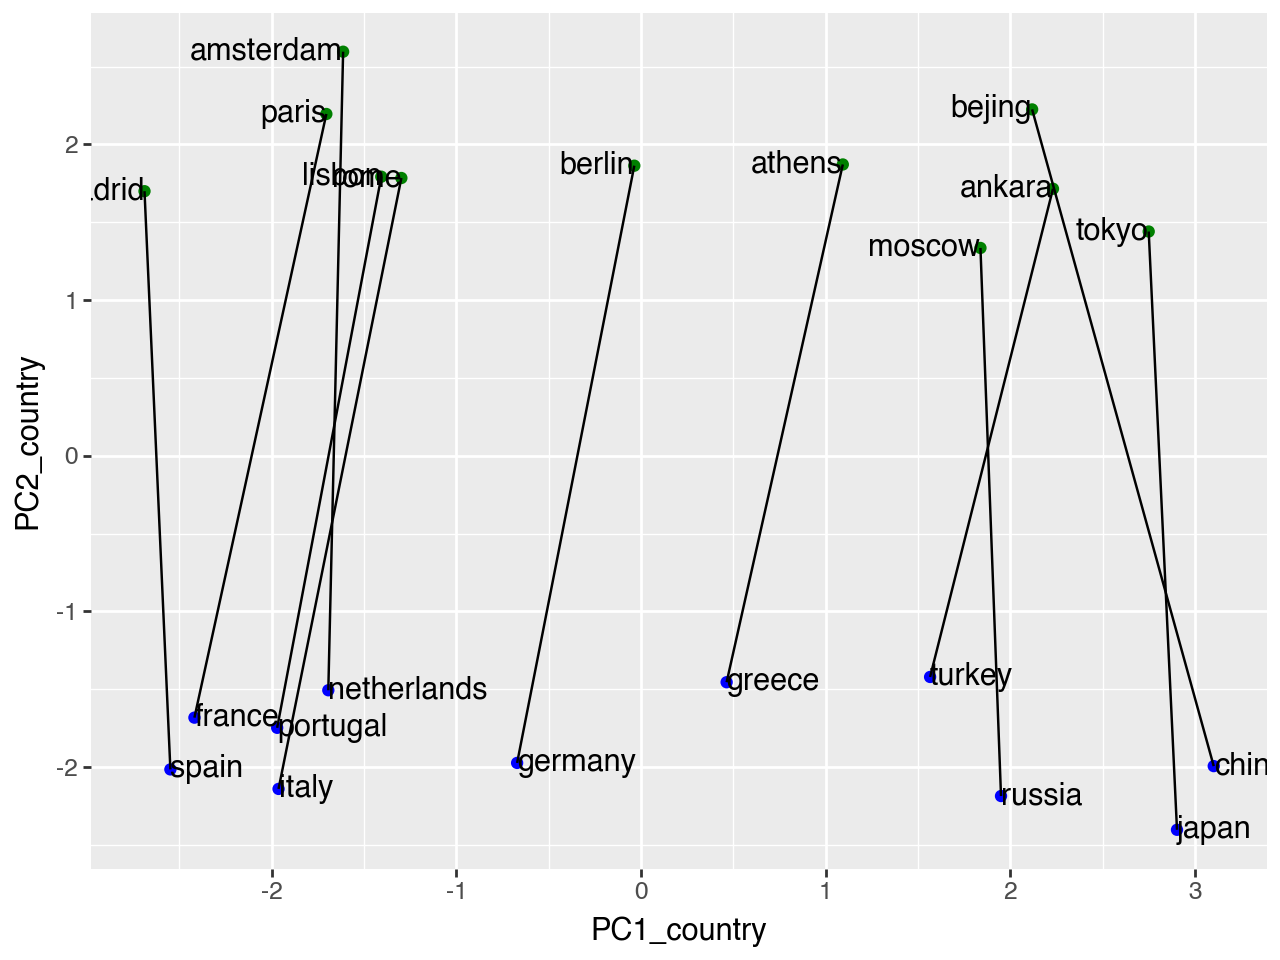

In [21]:
country_capitals = ['china', 'bejing', 'russia', 'moscow', 'japan', 'tokyo',
                    'turkey', 'ankara', 'spain', 'madrid', 'france', 'paris',
                    'portugal', 'lisbon', 'greece', 'athens', 'italy', 'rome',
                    'netherlands', 'amsterdam', 'germany', 'berlin']
plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([embeddings_index[w] for w in country_capitals]),
                         columns=['PC1', 'PC2'])
plot_word['word'] = country_capitals
plot_word['concept'] = pd.Series(['country', 'capital'] * int(len(plot_word) / 2))
plot_word['country'] = list(pd.Series(['china', 'russia', 'japan', 'turkey', 'spain', 'france', 'portugal', 'greece', 'italy', 'netherlands', 'germany']).repeat(2))
plot_word = plot_word.pivot(index='country', columns='concept')  # Needed for plotting in plotnine
plot_word.columns = ['_'.join(col).strip() for col in plot_word.columns.values]

gg = (
    ggplot(plot_word) +
      geom_point(aes(x='PC1_country', y='PC2_country'), color='blue') +
      geom_text(aes(x='PC1_country', y='PC2_country', label='word_country'), ha='left') +
      geom_point(aes(x='PC1_capital', y='PC2_capital'), color='green') +
      geom_text(aes(x='PC1_capital', y='PC2_capital', label='word_capital'), ha='right') +
      geom_segment(aes(x = 'PC1_country', xend='PC1_capital', y='PC2_country', yend='PC2_capital'))
)
gg

Dit gaat zelfs zo ver dat we dat je hier min-of-meer mee kunt rekenen. Hieronder zie je wat er gebeurt als je 'paris' - 'france' + 'poland' uitrekend en dan als uitkomst het dichtsbijzijnde woord pakt. 

In [22]:
from scipy.spatial import cKDTree

# Represent the embeddings as a matrix, needed for search with cKDTree
word_indices = pd.Series(list(embeddings_index.keys()))
cKDTree_embedding_matrix = np.array(list(embeddings_index.values()))

# Perform some vector magic with embeddings
find_capital_poland = embeddings_index['paris'] - embeddings_index['france'] + embeddings_index['poland']
closest_word = cKDTree(cKDTree_embedding_matrix).query(find_capital_poland, k=1) #zoek de k dichtsbijzijnde neighbors op
word_indices[closest_word[1]]

'warsaw'

# Thema 3 werkcollege 2: Recurrent Neural Networks
Genoeg spielerij met word_embeddings en terug naar onze videogames dataset. Nu we onze data in een bruikbaar formaat hebben kunnen we ons netwerk verder gaan opbouwen en trainen. We beginnen met het toevoegen van onze 1e SimpleRNN layer.

In [ ]:
#vervang de flatten layer met een SimpleRNN layer met 32 nodes

In [ ]:
#compile en fit epochs = 3

In [ ]:
#plot de accuracy en validated accuracy

Wat valt hier op?

Eventueel kun je het netwerk nog wat dieper trainer door er 1 of meerdere extra SimpleRNN layers aan toe te voegen. Gezien de tijd die het trainen van dit netwerk zou kosten gaan we dat nu even niet doen. Mocht je het wel thuis willen proberen, let er dan op dat je de juiste output 'returned'.

Nu is een SimpleRNN eigenlijk wat te simpel om de complexiteit van tekst te vatten, daarom vervangen we onze simpleRNN_layer door een LSTM layer met voor het gemak ook maar 32 neurons.

In [ ]:
#vervang de simpleRNN_layer door een LSTM_layer met 32 neurons epochs=10

In [ ]:
#plot de accuracy en validated accuracy

Wat valt hier op?

We proberen het nog eens met een 2e LSTM-laag ook met 32 neurons (let weer op de return sequence).

In [ ]:
#voeg een 2e LSTM laag toe, compile, fit en plot de (validated) accuracy

Voegt dit veel toe? 

Een alternatief voor LSTM-layers zijn GRU-layer, vervang daarom de LSTM-layers door GRU-layers.

In [ ]:
#Vervang de LSTM-layers door GRU-layers, compile, fit en plot de (validated) accuracy

Wat zijn de verschillen t.o.v. ons model met LSTM layer? 

Aangezien ons model nog steeds overfit voegen we aan de 1e GRU-layer een dropout en een recurrent dropout van 0.2 toe. Ivm performance beperken we ons tot 2 epochs (het punt waar de vorige ging overfitten) en forceren we het model op de cpu te draaien. 

In [ ]:
#Voeg aan de 1e GRU layer een dropout en recurrentdropout van 0.2 toe, compile fit en plot
#NB: beperkt je ivm de performance tot 2 epochs en forceer op cpu
# with tf.device('/cpu:0'):
#    history = model.fit(.....)


Wat zien we gebeuren?

Een andere optie om te verkennen is het bi-directioneel maken van 1 of beide GRU layers. Ivm de performance schrappen we de recurrent_dropout (de dropout blijft).

In [ ]:
#maak beide GRU-layers bi-directional, schrap de recurrent_dropout. Compile, fit (10 epochs) en plot de (validated) accuracy.

Hoeveel effect heeft dit?

Tot slot kijken we naar het effect als we onze GRU-layers vervangen door conv1d_layers, met bijbehorende maxpooling 1d en flatten layers

In [ ]:
#Vervang beide GRU layers door Conv1D_layers, een MaxPooling1d_layer, en een flatten_layer. Compile, Fit en Plot

Hoeveel effect heeft dit? 

Wat kun je zeggen over het gebruik van RNN-layers voor sentiment-analyse?

In dit geval lijken de RNN layers een beperkt effect te hebben. Bij heel kleine datasets is het zo dat een bag-of-words benadering zoals met alleen een embedding het vaak beter doen RNN's. De belangrijkste oorzaak zit hem in <u>de hoeveelheid samples t.o.v. de gemiddelde sample lengte </u> (hier afgekapt op 100).  Een richtlijn uit cholet p349 is dat als het <u> aantal samples gedeeld door de gemiddelde sample length < 1500</u> een bag-of-words methode beter werkt dan een transformer of een RNN. In deze casus trainen we met 90.000 reviews en 50 woorden = 1800 waardoor we nog maar heel beperkt boven deze vuistregel zitten